In [573]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3


In [574]:
#Load the csv files
the_movie_db_df = pd.read_csv('zippedData/tmdb.movies.csv')
gross_df = pd.read_csv('zippedData/bom.movie_gross.csv')
tomato_movieinfo_df = pd.read_csv('zippedData/rt.movie_info.tsv', sep = '\t')
tomato_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv', sep = '\t', encoding = 'latin-1')
tn_movie_budgets_db = pd.read_csv('zippedData/tn.movie_budgets.csv')

In [575]:
#Load the SQL database file and establish connection
conn = sqlite3.connect('zippedData/im.db')

In [576]:
#Convert money string into money integer so it can be used as a number.
def money_to_int(string):
    return int(string.replace('$', '').replace(',', ''))

## Compare average rating to profit
in order to determine if higher rated movies profit more. This will be useful since if there if a strong correlation, then voting average can be used as a stand-in for actual profits. Then, you can make comparisons of ratings vs. genre, etc to make statements about profitability.

In [577]:
#Replace the name in tn movie db so that it can be merged with the movie db dataset (column name must be the same)
tn_movie_budgets_db = tn_movie_budgets_db.rename({'movie': "title"}, axis='columns')
tn_movie_budgets_db_merge_budgets = tn_movie_budgets_db.merge(the_movie_db_df, how='inner',on='title')
tn_movie_budgets_db_merge_budgets['ww_float_gross'] = tn_movie_budgets_db_merge_budgets['worldwide_gross'].map(money_to_int)
tn_movie_budgets_db_merge_budgets['float_budget'] = tn_movie_budgets_db_merge_budgets['production_budget'].map(money_to_int)
tn_movie_budgets_db_merge_budgets['profit'] = tn_movie_budgets_db_merge_budgets['ww_float_gross'] - tn_movie_budgets_db_merge_budgets['float_budget']


The correlation between average rating and profits is: 0.1971


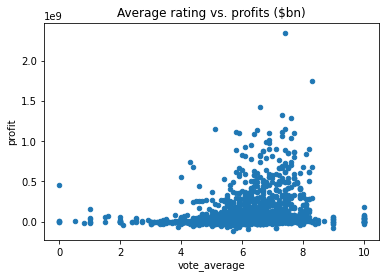

In [578]:
#Plot profit vs. average rating in a scatter plot and see if there is a strong linear relationship between the two.
fig, ax = plt.subplots()
tn_movie_budgets_db_merge_budgets.plot.scatter('vote_average','profit', ax = ax)
vote_vs_profit_correlation = tn_movie_budgets_db_merge_budgets[['vote_average','profit']].corr().iloc[0,1]
print("The correlation between average rating and profits is: " + str(round(tn_movie_budgets_db_merge_budgets[['vote_average','profit']].corr().iloc[0,1],4)))
plt.title('Average rating vs. profits ($bn)');

Determine percentage of fresh vs. not fresh movies by genre within the rotten tomatoes dataset.

Steps:

1. Need to clean the genre column in the Rotten Tomatoes movie info data set.
2. Make a set of columns for each genre listing true/false for each entry to identify which genre the movie is in.
3. Build a dictionary that prints 

In [579]:
#Get list of unique genres
tomato_movieinfo_df.dropna(subset=['genre'],inplace=True)
unique_genres = []
for genres in list(tomato_movieinfo_df['genre']):
    for genre in genres.split('|'):
        unique_genres.append(genre)
unique_genres = set(unique_genres)

In [580]:
#This cell creates a boolean matrix representing the genres that are in each movie. That way, movies can be filtered by a single genre
#and statements can be made on a genre-by-genre basis.
for genre in unique_genres:
    tomato_movieinfo_df[genre] = tomato_movieinfo_df['genre'].map(lambda x: genre in x)

In [581]:
#MERGE the two rotten tomatoes databases.
tomato_movieinfo_df_reviews_merged = tomato_movieinfo_df.merge(tomato_reviews_df, on = 'id', how = 'inner')

In [582]:
#Creates a "fresh_by_genre" dictionary that lists the ratio fresh/(fresh + not fresh), or the percentage of movies in that genre that are considered "fresh".
#Useful measure to see how well received different genres are, in general, by Rotten Tomatoes.
fresh_by_genre = {}

for genre in unique_genres:
    num_fresh = tomato_movieinfo_df_reviews_merged.groupby(['fresh',genre]).count().xs('fresh').iloc[1,0]
    num_rotten = tomato_movieinfo_df_reviews_merged.groupby(['fresh',genre]).count().xs('rotten').iloc[1,0]
    percent_fresh = num_fresh/(num_rotten+num_fresh)
    fresh_by_genre[genre] = percent_fresh

In [583]:
#Sorts the fresh_by_genre dict by their values
fresh_by_genre = dict(sorted(fresh_by_genre.items(), key=lambda item: item[1]))

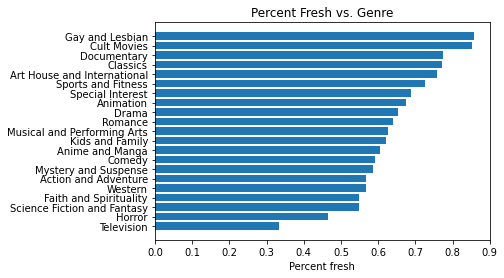

In [584]:
#plotting the dict as a bar chart
fig, ax = plt.subplots()
keys = list(fresh_by_genre.keys())
values = list(fresh_by_genre.values())
plt.barh(keys,values)
plt.xlabel('Percent fresh')
plt.title('Percent Fresh vs. Genre');

In [585]:
#This cell calculates profits. May not need this cell anymore if we're using ratio as the measure of success.
tn_movie_budgets_db['worldwide_gross'] = tn_movie_budgets_db['worldwide_gross'].map(money_to_int)
tn_movie_budgets_db['production_budget'] = tn_movie_budgets_db['production_budget'].map(money_to_int)
tn_movie_budgets_db['domestic_gross'] = tn_movie_budgets_db['domestic_gross'].map(money_to_int)
tn_movie_budgets_db['worldwide_profits'] = tn_movie_budgets_db['worldwide_gross'] - tn_movie_budgets_db['production_budget']
tn_movie_budgets_db.sort_values('worldwide_profits', ascending= False).head(10)

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,worldwide_profits
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
42,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220
33,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864
66,67,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794
26,27,"May 4, 2012",The Avengers,225000000,623279547,1517935897,1292935897
260,61,"Jul 15, 2011",Harry Potter and the Deathly Hallows: Part II,125000000,381193157,1341693157,1216693157
41,42,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,1148258224
112,13,"Jun 22, 2018",Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,1135772799


In [586]:
#This cell creates a column 'ratio' which is the ratio of worldwide gross to budget. Probably need to clean the data more after this.
tn_movie_budgets_db['release_date'] = tn_movie_budgets_db['release_date'].map(lambda x: str(pd.to_datetime(x)))
tn_unflated_db = tn_movie_budgets_db

tn_unflated_db['ratio'] = tn_unflated_db['worldwide_gross'] / tn_unflated_db['production_budget']

tn_unflated_db.replace(to_replace = 0, value = np.nan, inplace = True)
tn_unflated_db.dropna(inplace = True)
tn_unflated_db.sort_values('ratio', ascending = False).head()

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,worldwide_profits,ratio
5745,46,1972-06-30 00:00:00,Deep Throat,25000,45000000.0,45000000.0,44975000,1800.000000
5613,14,1980-03-21 00:00:00,Mad Max,200000,8750000.0,99750000.0,99550000,498.750000
5492,93,2009-09-25 00:00:00,Paranormal Activity,450000,107918810.0,194183034.0,193733034,431.517853
5679,80,2015-07-10 00:00:00,The Gallows,100000,22764410.0,41656474.0,41556474,416.564740
5406,7,1999-07-14 00:00:00,The Blair Witch Project,600000,140539099.0,248300000.0,247700000,413.833333


## Profitability by job category
Want to identify top performers in each category
1. merge imdb principals table with a table containing profitability.
2. Want to get .mean of some groupby. Groupby(primary_name) should be the solution.

In [587]:
#Join principals, persons, and movie basics from the im.db database
table_name_query = """SELECT person_id,movie_id,primary_name,category,primary_title
FROM principals
INNER JOIN persons
USING (person_id)
INNER JOIN  movie_basics
USING (movie_id)
"""
principals_persons_basics_df = pd.read_sql(table_name_query, conn)

In [588]:
#Join the principals_persons_basics_df dataframe and the gross_df dataframe (from bom.movie_gross.csv)
profit_by_job = principals_persons_basics_df.merge(gross_df, left_on = 'primary_title', right_on = 'title', how = 'inner')
profit_by_job = profit_by_job[['primary_name','category','title','domestic_gross','foreign_gross']]

In [589]:
#Merging movie basics and "unflated" to make the ratio table. This may be the source of the errors. Doubling up movie basics
table_name_query = """SELECT *
FROM movie_basics"""

imdb_movie_basics_df = pd.read_sql(table_name_query, conn)
ratio_genre_df = tn_unflated_db.merge(imdb_movie_basics_df,left_on = 'title', right_on = 'primary_title', how = 'inner')

In [590]:
ratio_genre_df.dropna(subset=['genres'],inplace=True)
unique_genres = []
for genres in list(ratio_genre_df['genres']):
    for genre in genres.split(','):
        unique_genres.append(genre)
unique_genres = set(unique_genres)

for genre in unique_genres:
    ratio_genre_df[genre] = ratio_genre_df['genres'].map(lambda x: genre in x)

In [591]:
profit_by_job_cleaned = profit_by_job.merge(ratio_genre_df, on = 'title').drop(['domestic_gross_x','foreign_gross','id','release_date','production_budget',
                                                                         'domestic_gross_y','worldwide_gross','movie_id','original_title','start_year',
                                                                         'runtime_minutes','genres','worldwide_profits','primary_title'],axis=1)

### Find top performers
create a dictionary that has the top 3 performers by ratio of any job category.
Filter by a specific genre, i.e. 'Drama' and then ccreate a multilayered index that sorts by job role and person's name.
Then build a dictionary that has the structure {job_category: [top 3 performers]}

In [592]:
#First print out unique genres for reference
unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

In [596]:
#Choose genre below. Change this according to the unique genres list
desired_genre = 'Comedy'

#This block should be the same for any genre
profit_by_job_cleaned = profit_by_job_cleaned.drop_duplicates(subset = ['primary_name','title']) #Drops anyone that appears multiple times in the same title
profit = profit_by_job_cleaned.loc[profit_by_job_cleaned[desired_genre] == True]
multilayer = profit[['category','primary_name','ratio']].groupby(['category','primary_name']).mean().sort_values(['category','ratio'], ascending = [True,False])
category_list = list(set(list(principals_df['category'])))
category_dict = {}
for category in category_list:
    if category not in (other for other in ['archive_sound','archive_footage','production_designer','self']):
        category_dict[category] = list(multilayer.xs(category).index[0:3])
category_dict

{'cinematographer': ['Donnacha Coffey', 'Francois Gray', 'Jordan T. Parrott'],
 'editor': ['Jules Saulnier', 'Luke Ciarrocchi', 'Nat Sanders'],
 'actress': ['Amy Ferguson', 'Anna Mouglalis', 'Anya Taylor-Joy'],
 'director': ['Deborah Kampmeier', 'Jamie Buckner', 'Kook-Hee Choi'],
 'composer': ['Eric Shaw', 'Leslie Graves', 'Michelangelo Sosnowitz'],
 'actor': ['Cathal Pendred', 'Christopher Guetig', 'Da-wit Lee'],
 'producer': ['Elizabeth Sorrell', 'John M. Roche', 'Laura Morton'],
 'writer': ['Simon Barrett', 'Reid Carolin', 'Branden Jacobs Jenkins']}